##############################################################################################
Conceptos y repaso de un systema de fibra optica 1.4
##############################################################################################

Created on Fri May 15 20:01:28 2021

Conceptos y repaso de un sistema de fibra optica

@author: Diego Villafani

Receptor y BER


In [21]:
#Comenzaremos con la modulacion del Laser con OOK

#Primero Importamos las librerias necesarias
import numpy as np
import matplotlib.pyplot as plt


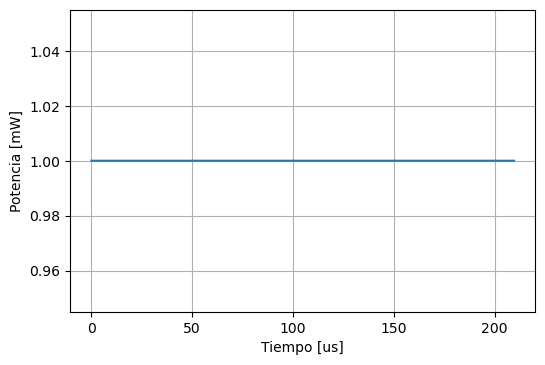

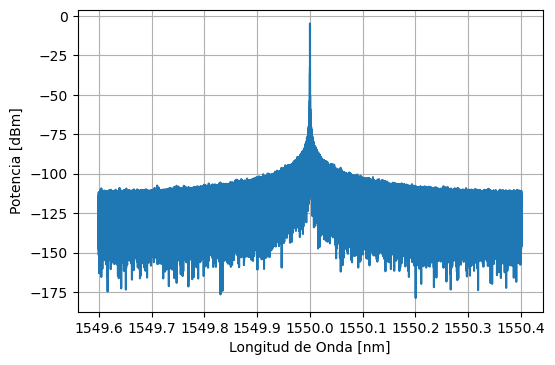

In [22]:
#Primero Generamos nuevamente el Laser simulado anteriormente.

#En la realidad, un laser en 1550nm es parecido con una señal senoidal, la cual oscila 
#a f=c/1550nm donde c es la velocidad de la luz en el vacio.
#En esta simulacion, consideramos que nuestro punto de referencia de la frequencua, la frequencia = 0,  es f=c/1550nm
# El Laser simulado estara en el espectro electromagnetico al rededor de 1550nm.
#Debemos entender que en esta simulación, utilizaremos la señal en banda base y asumimos que el laser esta en
#banda base.

Longitud_de_onda_del_laser_central=1550e-9 #Longitud de Onda en metros e-9 =nm

Potencia_dBm= 0 #Potencia en dBm

Sintonizar_Laser=0e9  #Sintonizar Laser respecto a 1550nm en Hz

#Creando Los parametros para la simulacion 
Potencia_mw=10**(Potencia_dBm/10)   #Potencia en mW
c  = 2.99792458e8                   #Velocidad de la luz
Frequencia_del_laser=c/Longitud_de_onda_del_laser_central    #Frequencia del Laser en Hz
frequencia_de_muestreo=2*50e9 #Span del OSA o rango de frequencias donde veremos la señal
numero_de_muestras=2**21

dt_samp=1/frequencia_de_muestreo #Delta del tiempo entre muestras

Tiempo_total=dt_samp*numero_de_muestras #Tiempo Total

Vector_tiempo=np.arange(0,(numero_de_muestras)*dt_samp,dt_samp) #Vector del Tiempo

Vector_frequencia=Frequencia_del_laser+(1/Tiempo_total)*np.arange(-numero_de_muestras/2,numero_de_muestras/2,1) #Vector de la frequencia

Vector_Longitud_de_onda=c/Vector_frequencia



#Creando el laser simulado

Laser_CW=np.sqrt(Potencia_mw*np.ones(numero_de_muestras)) #Laser CW= constant Wave

#Phase noise
varianza_de_fase = 2*np.pi*(100e3)*dt_samp 
fase_con_ruido=np.cumsum(np.sqrt(varianza_de_fase)*np.random.randn(numero_de_muestras))

#Laser Simulado en el tiempo
Laser=Laser_CW*np.exp(1j*2*np.pi*Sintonizar_Laser*Vector_tiempo+1j*fase_con_ruido)

#Convirtiendo la señal del tiempo a frequencia con FFT

Espectro=(np.abs(np.sqrt(dt_samp/numero_de_muestras)*np.fft.fft(Laser))**2)*(1/Tiempo_total)
Espectro_fft=np.append(Espectro[int(numero_de_muestras/2):numero_de_muestras],Espectro[0:int(numero_de_muestras/2)])


#Graficando el laser continuo en el tiempo
plt.grid(True)
plt.plot(Vector_tiempo*10e6,(np.abs(Laser)**2))
plt.ticklabel_format(useOffset=False)
plt.ylabel('Potencia [mW]')
plt.xlabel('Tiempo [us]')
plt.show()

#Graficando el espectro
plt.grid(True)
#plt.plot(Vector_frequencia/1e12,10*np.log10(Espectro_fft))
plt.plot(Vector_Longitud_de_onda*1e9,10*np.log10(Espectro_fft))
plt.ticklabel_format(useOffset=False)
plt.ylabel('Potencia [dBm]')
plt.xlabel('Longitud de Onda [nm]')
plt.show()




In [23]:
#Potencia total:
P_mean = np.mean(np.abs(Laser)**2)
10*np.log10(P_mean)

0.0

bits =[1. 0. 1. ... 1. 1. 0.]


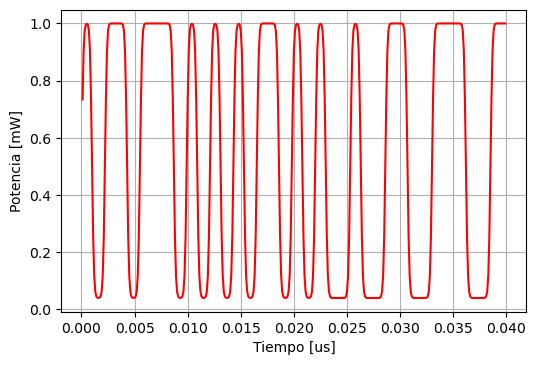

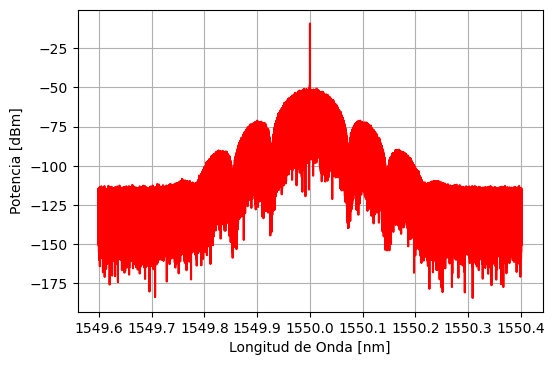

In [25]:
#Modulando el Laser

#Utilizamos la señal generada anteriormente de bits digitales

#Parametros de la señal
Amplitud_bit_1=1 #Amplitud
Tasa_de_transmission=10e9 #Tasa de transmision en bits por segundo

#Calculamos el Extinction ratio
Extinction_ratio=7 #dB 10*log10(amp_nivel_1/amp_nivel0)
level_0=1/(10**(Extinction_ratio/10));

#Numero total de bits para el tiempo graficado
numero_de_bits=np.around(Tiempo_total/(1/Tasa_de_transmission))

#Bits aleatorios
bits=np.random.randint(2, size=int(numero_de_bits)).astype('float')
print("bits =" +str(bits))

#Creando la señal
Vector_Señal=Amplitud_bit_1*bits.repeat(np.ceil(numero_de_muestras/len(bits)), axis=0)
Vector_Señal[Vector_Señal < 0.5] = level_0


#Filtramos simulando el filtro electrico
bandwidth = 0.8*Tasa_de_transmission  # Electrical Filter bandwidth [Hz]

#Filtro gausiano centrado en 0
df = 2*bandwidth/np.sqrt(2*np.log(2)) #3dB FWHM
Vector_frequencia_0=Vector_frequencia-Frequencia_del_laser
Hf = np.fft.fftshift(np.exp(-((Vector_frequencia_0)**2)/(df**2)))

Vector_Señal=np.fft.ifft(np.fft.fft(Vector_Señal[0:len(Hf)])*Hf)


#Agregamos ruido
noise = np.random.normal(0, 0.0, Vector_Señal.shape)
Vector_Señal = Vector_Señal + noise


#Laser Simulado en el tiempo
Laser_mod=Laser*Vector_Señal[0:len(Laser)]

#Convirtiendo la señal del tiempo a frequencia con FFT

Espectro=(np.abs(np.sqrt(dt_samp/numero_de_muestras)*np.fft.fft(Laser_mod))**2)*(1/Tiempo_total)
Espectro_fft=np.append(Espectro[int(numero_de_muestras/2):numero_de_muestras],Espectro[0:int(numero_de_muestras/2)])


#Graficando parte del laser modulado en el tiempo
plt.grid(True)
plt.plot(Vector_tiempo[1:int(Tasa_de_transmission/1e9*40)]*10e6,np.abs(Laser_mod[1:int(Tasa_de_transmission/1e9*40)])**2, color='red')
plt.ylabel('Potencia [mW]')
plt.xlabel('Tiempo [us]')
plt.show()

#Graficando el espectro
plt.grid(True)
#plt.plot(Vector_frequencia/1e12,10*np.log10(Espectro_fft))
plt.plot(Vector_Longitud_de_onda*1e9,10*np.log10(Espectro_fft), color='red')
plt.ticklabel_format(useOffset=False)
plt.ylabel('Potencia [dBm]')
plt.xlabel('Longitud de Onda [nm]')
plt.show()


In [26]:
#Potencia total:
P_mean = np.mean(np.abs(Laser_mod)**2)
10*np.log10(P_mean)

-3.058394919760766

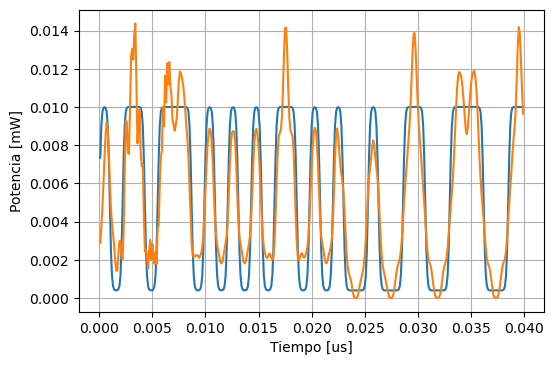

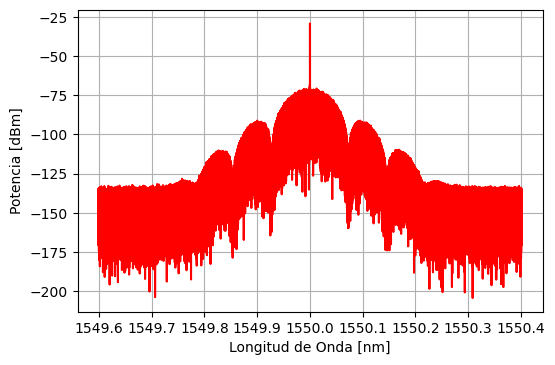

In [27]:
#Parametros de la fibra óptica
#
L=100*1e3 #Distancia en metros [m]

att_db=0.2e-3 #Atenuacion en la fibra optica en [db/m]
alpha=att_db*1e3*np.log(10)/10/1e3

#Parametro de la fibra optica
D=17e-6 #Parametro de dispersion chromatica [s/m^2]

#Beta2
beta2=D*(-Longitud_de_onda_del_laser_central**2)/2/np.pi/c #[s/m^2]
#Slope
S=0.06*(1e-12)/((1e-9)*(1e-9)*1e3) # [s/m^3]
#Beta3
beta3=(S-4*np.pi*c/(Longitud_de_onda_del_laser_central)**3*beta2)*(Longitud_de_onda_del_laser_central**2/(2*np.pi*c))**2 # [s^3/m]
omega= 2*np.pi/Tiempo_total*np.concatenate((np.arange(0,numero_de_muestras/2, 1),np.arange(-numero_de_muestras/2,0,1)))


#Aplicando Att
att_laser_mod=Laser_mod*np.exp(L*(-alpha/2))
#Aplicando Dispersion
att_dis_laser_mod = np.fft.ifft(np.fft.fft(att_laser_mod)*np.exp(-1j*1/2*beta2*L*omega**2-1j/6*beta3*L*omega**3))




#Convirtiendo la señal del tiempo a frequencia con FFT

Espectro=(np.abs(np.sqrt(dt_samp/numero_de_muestras)*np.fft.fft(att_dis_laser_mod))**2)*(1/Tiempo_total)
Espectro_fft=np.append(Espectro[int(numero_de_muestras/2):numero_de_muestras],Espectro[0:int(numero_de_muestras/2)])


#Graficando parte del laser modulado en el tiempo
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
plt.grid(True)
plt.plot(Vector_tiempo[1:int(Tasa_de_transmission/1e9*40)]*10e6,np.abs(att_laser_mod[1:int(Tasa_de_transmission/1e9*40)])**2,Vector_tiempo[1:int(Tasa_de_transmission/1e9*40)]*10e6,np.abs(att_dis_laser_mod[1:int(Tasa_de_transmission/1e9*40)])**2)
plt.ylabel('Potencia [mW]')
plt.xlabel('Tiempo [us]')
plt.show()

#Graficando el espectro
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
plt.grid(True)
#plt.plot(Vector_frequencia/1e12,10*np.log10(Espectro_fft))
plt.plot(Vector_Longitud_de_onda*1e9,10*np.log10(Espectro_fft), color='red')
plt.ticklabel_format(useOffset=False)
plt.ylabel('Potencia [dBm]')
plt.xlabel('Longitud de Onda [nm]')
plt.show()


In [28]:
#Potencia total:
P_mean = np.mean(np.abs(att_dis_laser_mod)**2)
10*np.log10(P_mean)

-23.05839491976077

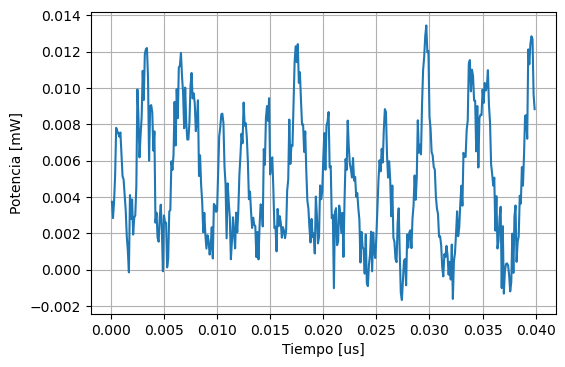

In [29]:
#Simulacion del Receptor

Responsividad=0.9
Ruido=0.001

Rx_I=Responsividad*abs(att_dis_laser_mod)**2

noise = np.random.normal(0, Ruido, Rx_I.shape)
Rx_I_noise = Rx_I + noise

#Graficando parte del laser modulado en el tiempo
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
plt.grid(True)
plt.plot(Vector_tiempo[1:int(Tasa_de_transmission/1e9*40)]*10e6,Rx_I_noise[1:int(Tasa_de_transmission/1e9*40)])
plt.ylabel('Potencia [mW]')
plt.xlabel('Tiempo [us]')
plt.show()


In [30]:
#Calculo del BER
#Decisión entre 0 y 1:
Limite = np.mean(Rx_I_noise)
samples_per_bit=int(np.ceil(numero_de_muestras/len(bits)))
#Recuperacion del bit muestreando en el medio del bit
bits_rx=Rx_I_noise[5:-1:samples_per_bit]
#Decision entre 0 y 1
bits_rx[bits_rx>Limite]=1
bits_rx[bits_rx<=Limite]=0


#Calculo del BER 
BER=(len(bits_rx)-np.sum(bits_rx==bits[0:len(bits_rx)]))/len(bits_rx)

print('BER ='+str(BER))

BER =0.0014634146341463415


Rx Power= -5.06dBm BER =0.0
Rx Power= -9.06dBm BER =0.0
Rx Power= -13.06dBm BER =0.0
Rx Power= -17.06dBm BER =0.0
Rx Power= -20.06dBm BER =0.0
Rx Power= -21.06dBm BER =0.0
Rx Power= -22.06dBm BER =0.0
Rx Power= -23.06dBm BER =1.049042748492001e-05
Rx Power= -24.06dBm BER =0.00034618410700236035
Rx Power= -25.06dBm BER =0.0033831628638867034
Rx Power= -26.06dBm BER =0.016239181746656176
Rx Power= -27.06dBm BER =0.043624442696039864
Rx Power= -28.06dBm BER =0.08591135588775242
Rx Power= -29.06dBm BER =0.13881458169420405
Rx Power= -30.06dBm BER =0.19556254917387883
Rx Power= -5.06dBm BER =0.0
Rx Power= -9.06dBm BER =0.0
Rx Power= -13.06dBm BER =0.0
Rx Power= -17.06dBm BER =0.0
Rx Power= -20.06dBm BER =0.0
Rx Power= -21.06dBm BER =0.0
Rx Power= -22.06dBm BER =0.00013113034356150013
Rx Power= -23.06dBm BER =0.0014004720692368214
Rx Power= -24.06dBm BER =0.009000786782061369
Rx Power= -25.06dBm BER =0.03200104904274849
Rx Power= -26.06dBm BER =0.07124573826383425
Rx Power= -27.06dBm BER =0.

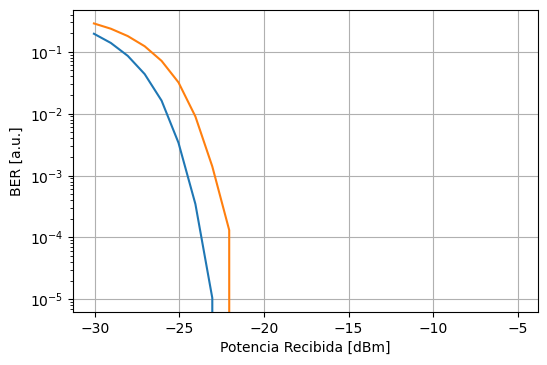

In [34]:
#Making a BER curve

Distancias=np.concatenate((np.arange(10,80,20),np.arange(85,140,5)))
BER_l=[]
Rx_p=[]

for ind in np.arange(0,len(Distancias)):
    #Parametros de la fibra óptica
    #
    L=Distancias[ind]*1e3 #Distancia en metros [m]

    att_db=0.2e-3 #Atenuacion en la fibra optica en [db/m]
    alpha=att_db*1e3*np.log(10)/10/1e3

    #Parametro de la fibra optica
    D=0%17e-6 #Parametro de dispersion chromatica [s/m^2]

    #Beta2
    beta2=D*(-Longitud_de_onda_del_laser_central**2)/2/np.pi/c #[s/m^2]
    #Slope
    S=0.06*(1e-12)/((1e-9)*(1e-9)*1e3) # [s/m^3]
    #Beta3
    beta3=(S-4*np.pi*c/(Longitud_de_onda_del_laser_central)**3*beta2)*(Longitud_de_onda_del_laser_central**2/(2*np.pi*c))**2 # [s^3/m]
    omega= 2*np.pi/Tiempo_total*np.concatenate((np.arange(0,numero_de_muestras/2, 1),np.arange(-numero_de_muestras/2,0,1)))


    #Aplicando Att
    att_laser_mod=Laser_mod*np.exp(L*(-alpha/2))
    #Aplicando Dispersion
    att_dis_laser_mod = np.fft.ifft(np.fft.fft(att_laser_mod)*np.exp(-1j*1/2*beta2*L*omega**2-1j/6*beta3*L*omega**3))


    #Rx Power
    P_mean = np.mean(np.abs(att_dis_laser_mod)**2)
    Rx_p.append(10*np.log10(P_mean))


    #Simulacion del Receptor

    Responsividad=0.9
    Ruido=0.001

    Rx_I=Responsividad*abs(att_dis_laser_mod)**2

    noise = np.random.normal(0, Ruido, Rx_I.shape)
    Rx_I_noise = Rx_I + noise


    #Calculo del BER
    #Decisión entre 0 y 1:
    Limite = np.mean(Rx_I_noise)
    samples_per_bit=int(np.ceil(numero_de_muestras/len(bits)))
    #Recuperacion del bit muestreando en el medio del bit
    bits_rx=Rx_I_noise[5:-1:samples_per_bit]
    #Decision entre 0 y 1
    bits_rx[bits_rx>Limite]=1
    bits_rx[bits_rx<=Limite]=0


    #Calculo del BER 
    BER=(len(bits_rx)-np.sum(bits_rx==bits[0:len(bits_rx)]))/len(bits_rx)
    print('Rx Power= '+str(np.round(10*np.log10(P_mean),2))+ 'dBm BER ='+str(BER))
    BER_l.append(BER)

    
BER_l2=[]
Rx_p2=[]

for ind in np.arange(0,len(Distancias)):
    #Parametros de la fibra óptica
    #
    L=Distancias[ind]*1e3 #Distancia en metros [m]

    att_db=0.2e-3 #Atenuacion en la fibra optica en [db/m]
    alpha=att_db*1e3*np.log(10)/10/1e3

    #Parametro de la fibra optica
    D=17e-6 #Parametro de dispersion chromatica [s/m^2]

    #Beta2
    beta2=D*(-Longitud_de_onda_del_laser_central**2)/2/np.pi/c #[s/m^2]
    #Slope
    S=0.06*(1e-12)/((1e-9)*(1e-9)*1e3) # [s/m^3]
    #Beta3
    beta3=(S-4*np.pi*c/(Longitud_de_onda_del_laser_central)**3*beta2)*(Longitud_de_onda_del_laser_central**2/(2*np.pi*c))**2 # [s^3/m]
    omega= 2*np.pi/Tiempo_total*np.concatenate((np.arange(0,numero_de_muestras/2, 1),np.arange(-numero_de_muestras/2,0,1)))


    #Aplicando Att
    att_laser_mod=Laser_mod*np.exp(L*(-alpha/2))
    #Aplicando Dispersion
    att_dis_laser_mod = np.fft.ifft(np.fft.fft(att_laser_mod)*np.exp(-1j*1/2*beta2*L*omega**2-1j/6*beta3*L*omega**3))


    #Rx Power
    P_mean = np.mean(np.abs(att_dis_laser_mod)**2)
    Rx_p2.append(10*np.log10(P_mean))


    #Simulacion del Receptor

    Responsividad=0.9
    Ruido=0.001

    Rx_I=Responsividad*abs(att_dis_laser_mod)**2

    noise = np.random.normal(0, Ruido, Rx_I.shape)
    Rx_I_noise = Rx_I + noise


    #Calculo del BER
    #Decisión entre 0 y 1:
    Limite = np.mean(Rx_I_noise)
    samples_per_bit=int(np.ceil(numero_de_muestras/len(bits)))
    #Recuperacion del bit muestreando en el medio del bit
    bits_rx=Rx_I_noise[5:-1:samples_per_bit]
    #Decision entre 0 y 1
    bits_rx[bits_rx>Limite]=1
    bits_rx[bits_rx<=Limite]=0


    #Calculo del BER 
    BER=(len(bits_rx)-np.sum(bits_rx==bits[0:len(bits_rx)]))/len(bits_rx)
    print('Rx Power= '+str(np.round(10*np.log10(P_mean),2))+ 'dBm BER ='+str(BER))
    BER_l2.append(BER)
    
#Graficando BER vs Rx Power
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
plt.grid(True)
plt.plot(Rx_p,BER_l,Rx_p2,BER_l2)
plt.yscale('log')
plt.ylabel('BER [a.u.]')
plt.xlabel('Potencia Recibida [dBm]')
plt.show()